In [224]:
import numpy as np
np.random.seed(3)
from pybedtools import BedTool
import pybedtools
import pandas as pd
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout,BatchNormalization,Activation
from keras.layers import Conv1D, MaxPooling1D,Conv2D,MaxPooling2D,GlobalAveragePooling1D
from keras.layers import Dropout
from keras.optimizers import Adam
from keras import regularizers as kr
from keras import initializers
from keras.callbacks import EarlyStopping
from keras.utils import np_utils, to_categorical
# custom R2-score metrics for keras backend
from tensorflow.python.keras import backend as K
import matplotlib.pyplot as plt

import os
from sklearn.metrics import r2_score
from tensorflow.python.keras.callbacks import EarlyStopping

In [225]:
def read_data(bed_file,fasta_file):
    #apply bedtools to read fasta files '/home/h5li/methylation_DMR/data/DMR_coordinates_extended_b500.bed'
    a = pybedtools.example_bedtool( bed_file )
    # '/home/h5li/methylation_DMR/data/mm10.fasta'
    fasta = pybedtools.example_filename( fasta_file )
    a = a.sequence(fi=fasta)
    seq = open(a.seqfn).read()
    #read and extract DNA sequences 
    DNA_seq_list = seq.split('\n')
    DNA_seq_list.pop()
    DNA_seq = []
    m = 10000
    n = 0
    for index in range(len(DNA_seq_list)//2):
        DNA_seq.append(DNA_seq_list[index*2 + 1].upper())
        if len(DNA_seq_list[index*2 + 1]) < m:
            m = len(DNA_seq_list[index*2 + 1])
        if len(DNA_seq_list[index*2 + 1]) > n:
            n = len(DNA_seq_list[index*2 + 1])
    print('The shortest length of DNA sequence is {0}bp'.format(m))
    print('The longest length of DNA sequence is {0}bp'.format(n))
    return DNA_seq,n,m

In [226]:
def extend_Data(targetLength,dnaSeqList):
    newDNAList = []
    for seq in dnaSeqList:
        if len(seq) < targetLength:
            diff = targetLength - len(seq)
            if diff % 2 == 0:
                seq += 'N' * (diff//2)
                seq = 'N' * (diff//2) + seq
            if diff % 2 ==1:
                seq += 'N' *(diff//2)
                seq = 'N' * (diff//2 + 1) + seq
        newDNAList.append(seq)
    return newDNAList

def chop_Data(targetLength,dnaSeqList):
    #chop DNA sequences to have same length
    Uni_DNA = []
    for s in dnaSeqList:
        if len(s) < targetLength:
            print('Exceptions!')
        diff = len(s) - targetLength
        if diff % 2 == 0:
            side = diff // 2
            Uni_DNA.append(s[side:-side])
        else:
            right = diff // 2
            left = diff// 2 + 1
            Uni_DNA.append(s[left:-right])
    return Uni_DNA

In [227]:
#below are helper methods
def data_aug(seq):
    new_seq = []
    for i in range(len(seq)):
        l = seq[i]
        if l == 'A':
            new_seq.append( 'T' )
        elif l == 'C':
            new_seq.append( 'G' )
        elif l == 'G':
            new_seq.append( 'C' )
        elif l == 'T':
            new_seq.append( 'A' )
        else:
            new_seq.append( 'N' )
    return new_seq

def data_rev(seq):
    new_seq = [None] * len(seq)
    for i in range(len(seq)):
        new_seq[-i] = seq[i]
    return new_seq      

def mse_keras(y_true, y_pred):
    SS_res =  K.sum( K.square( y_true - y_pred ) ) 
    SS_tot = K.sum( K.square( y_true - K.mean( y_true ) ) ) 
    return ( SS_res/SS_tot)

def R2_score(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot) )

In [228]:
def preprocess_data(DNA_seq):

    train_size = len(DNA_seq)

    #One hot encoding 
    DNA = []
    for u in DNA_seq:
        sequence_vector = []
        for c in u:
            if c == 'A':
                sequence_vector.append([1,0,0,0])
            elif c == 'C':
                sequence_vector.append([0,1,0,0])
            elif c == 'G':
                sequence_vector.append([0,0,1,0])
            else:
                sequence_vector.append([0,0,0,1])
        DNA.append(np.array(sequence_vector))
    DNA = np.array(DNA)
    print(DNA.shape)
    return DNA

In [229]:
def Formalize_Data(DNA_seq, methylation_file, target_length, cell_type):
    #Read Methylation level
    labels = list(pd.read_csv(methylation_file,header = None)[cell_type])
    train_labels = np.array(labels)
    training_seq_shape = (len(DNA_seq),target_length,4)
    train_data = DNA_seq.reshape(training_seq_shape)
    return train_data,train_labels

In [230]:
bed_file_path = '/home/h5li/methylation_DMR/data/DMR_coordinates_extended_b500.bed'
fasta_file_path = '/home/h5li/methylation_DMR/data/mm10.fasta'
methylation_file_path = '../../data/Mouse_DMRs_methylation_level.csv'
total_counts_file_path ='../../data/Mouse_DMRs_counts_total.csv'
methy_counts_file_path = '../../data/Mouse_DMRs_counts_methylated.csv'
    

cell_type = 5
apply_sample_weight = False
    
DNA_seq,long_length,short_length = read_data(bed_file_path, fasta_file_path)   

target_length = 200

The shortest length of DNA sequence is 1407bp
The longest length of DNA sequence is 5829bp


In [231]:
DNA_seq = chop_Data(target_length,DNA_seq)

In [232]:
print(len(DNA_seq[0]))

200


In [233]:
#This Part of code id used to check the validity of CNN architecture

#We plan to start from single pattern in DNA sequence and the DNA methylation level is 0 or 1.
#Then we try with the same pattern and we use a random normal distribution to evaluate the
#methylation level to further simulate the DMR regions


# single pattern starts from here

# find out the most common patter first
Kmers_count = pd.read_csv('/cndd/emukamel/snmCSeq/DMR/Kmer_Features/Kmers_K4_counts.csv',header = None)
Kmers_count = Kmers_count.drop([0],axis = 1)

maxNum = 0
maxIndex = 0
for n in Kmers_count.columns:
    if Kmers_count[n].sum() > maxNum:
        maxNum = Kmers_count[n].sum()
        maxIndex = n - 1
print(maxIndex, maxNum)

targetKmers = pd.read_csv('/cndd/emukamel/snmCSeq/DMR/Kmer_Features/Kmers_K4_sequences.csv',header = None)[0][maxIndex]
#targetKmers += 'G'
print(targetKmers)

methylation_level = []
DNA_len100 = []
m1 = 0
m0 = 0
for n in range(len(DNA_seq)):
    if targetKmers in DNA_seq[n] and m1<30000:
        methylation_level.append(1)
        DNA_len100.append(DNA_seq[n])
        m1 += 1
    elif (targetKmers not in DNA_seq[n]) and m0 < 30000:
        methylation_level.append(0)
        DNA_len100.append(DNA_seq[n])
        m0 += 1
print(sum(methylation_level)/len(methylation_level))

73 980424
TTTC
0.6085439571585054


In [234]:
DNA = preprocess_data(DNA_len100)

(49298, 200, 4)


In [235]:
train_data,train_labels = Formalize_Data(DNA, methylation_file_path, target_length, cell_type)
#train_labels = train_labels - np.full((train_labels.shape),np.mean(train_labels))
#train_labels = to_categorical(np.array(methylation_level))
train_labels = np.array(methylation_level)

In [236]:
init = initializers.RandomNormal(mean=1, stddev=0.5, seed=None)
k_r = kr.l2(1e-6)

In [237]:
train_data.shape

(49298, 200, 4)

In [239]:
nfilt = 1
filtlength = 4
seqlen = target_length;
model = Sequential()
model.add(Conv1D(filters=nfilt, kernel_size=filtlength,kernel_initializer = 'ones',
                 input_shape=(seqlen,4), activation='relu'))
model.add(GlobalAveragePooling1D())
model.add(Dense(1, kernel_initializer='ones' ,activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_29 (Conv1D)           (None, 197, 1)            17        
_________________________________________________________________
global_average_pooling1d_29  (None, 1)                 0         
_________________________________________________________________
dense_28 (Dense)             (None, 1)                 2         
Total params: 19
Trainable params: 19
Non-trainable params: 0
_________________________________________________________________


In [ ]:
callbacks = [EarlyStopping(monitor='val_loss', patience=10,mode = 'min')]
history = model.fit(train_data, train_labels, epochs=500, callbacks = callbacks,
                    validation_split = 0.25,shuffle = False,
                        batch_size=100,verbose=1)

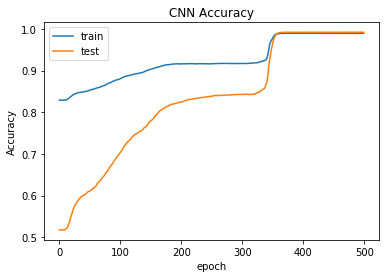

In [199]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('CNN Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [22]:
np.mean(train_labels)

0.4125111622879165